In [1]:
import numpy as np
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt

In [2]:
from sklearn import tree,preprocessing
from sklearn.model_selection import train_test_split

In [3]:
#newer for me
from subprocess import check_output
print(check_output(["ls"]).decode("utf-8"))

FPA_FOD_20170508.sqlite
Untitled.ipynb
Working_with_sqlite3AndPandas.ipynb



In [4]:
#establishing the connection with sqlite database
conn=sqlite3.connect("FPA_FOD_20170508.sqlite")

In [5]:
data=pd.read_sql("SELECT FIRE_YEAR,STAT_CAUSE_DESCR,LATITUDE,LONGITUDE,STATE,DISCOVERY_DATE,FIRE_SIZE FROM 'Fires'", conn)
print(data.head()) #check the data

   FIRE_YEAR STAT_CAUSE_DESCR   LATITUDE   LONGITUDE STATE  DISCOVERY_DATE  \
0       2005    Miscellaneous  40.036944 -121.005833    CA       2453403.5   
1       2004        Lightning  38.933056 -120.404444    CA       2453137.5   
2       2004   Debris Burning  38.984167 -120.735556    CA       2453156.5   
3       2004        Lightning  38.559167 -119.913333    CA       2453184.5   
4       2004        Lightning  38.559167 -119.933056    CA       2453184.5   

   FIRE_SIZE  
0       0.10  
1       0.25  
2       0.10  
3       0.10  
4       0.10  


In [6]:
#See the Date carefully it is in the Julian Format
data['DATE'] = pd.to_datetime(data['DISCOVERY_DATE'] - pd.Timestamp(0).to_julian_date(), unit='D')
print(data.head()) #check the data

   FIRE_YEAR STAT_CAUSE_DESCR   LATITUDE   LONGITUDE STATE  DISCOVERY_DATE  \
0       2005    Miscellaneous  40.036944 -121.005833    CA       2453403.5   
1       2004        Lightning  38.933056 -120.404444    CA       2453137.5   
2       2004   Debris Burning  38.984167 -120.735556    CA       2453156.5   
3       2004        Lightning  38.559167 -119.913333    CA       2453184.5   
4       2004        Lightning  38.559167 -119.933056    CA       2453184.5   

   FIRE_SIZE       DATE  
0       0.10 2005-02-02  
1       0.25 2004-05-12  
2       0.10 2004-05-31  
3       0.10 2004-06-28  
4       0.10 2004-06-28  


In [7]:
data.shape

(1880465, 8)

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1880465 entries, 0 to 1880464
Data columns (total 8 columns):
FIRE_YEAR           int64
STAT_CAUSE_DESCR    object
LATITUDE            float64
LONGITUDE           float64
STATE               object
DISCOVERY_DATE      float64
FIRE_SIZE           float64
DATE                datetime64[ns]
dtypes: datetime64[ns](1), float64(4), int64(1), object(2)
memory usage: 114.8+ MB


In [9]:
#See the Memory usage required here more than 100 Mb

In [10]:
#small representation of the usage of the Datetime Object
import pandas as pd 
  
# Create the DatetimeIndex 
# Here 'D' represents Daily frequency 
didx = pd.DatetimeIndex(start ='2014-08-01 10:05:45', freq ='D', 
                               periods = 5, tz ='Asia/Calcutta') 
  
# Print the DatetimeIndex 
print(didx.month) 

Int64Index([8, 8, 8, 8, 8], dtype='int64')


/home/tarun/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  import sys


In [11]:
#using the datetime python object to extract some useful information like weekday name and othet necessary features
data['MONTH'] = pd.DatetimeIndex(data['DATE']).month
data['DAY_OF_WEEK'] = data['DATE'].dt.weekday_name
df_orig = data.copy() #I will use this copy later
print(data.head())

   FIRE_YEAR STAT_CAUSE_DESCR   LATITUDE   LONGITUDE STATE  DISCOVERY_DATE  \
0       2005    Miscellaneous  40.036944 -121.005833    CA       2453403.5   
1       2004        Lightning  38.933056 -120.404444    CA       2453137.5   
2       2004   Debris Burning  38.984167 -120.735556    CA       2453156.5   
3       2004        Lightning  38.559167 -119.913333    CA       2453184.5   
4       2004        Lightning  38.559167 -119.933056    CA       2453184.5   

   FIRE_SIZE       DATE  MONTH DAY_OF_WEEK  
0       0.10 2005-02-02      2   Wednesday  
1       0.25 2004-05-12      5   Wednesday  
2       0.10 2004-05-31      5      Monday  
3       0.10 2004-06-28      6      Monday  
4       0.10 2004-06-28      6      Monday  


In [12]:
'''The purpose of this kernel is to create some ML that can correctly determine
the cause of fire so we can start by looking at the causes of fires in the data:'''

'The purpose of this kernel is to create some ML that can correctly determine\nthe cause of fire so we can start by looking at the causes of fires in the data:'

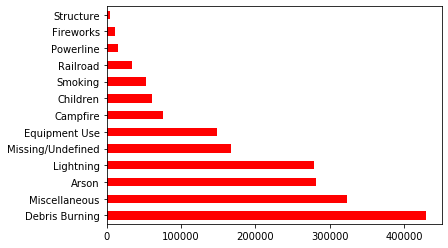

In [13]:
data['STAT_CAUSE_DESCR'].value_counts().plot(kind='barh',color='r')
plt.show()

In [14]:
'''
There are 13 causes listed in the dataset. This is quite a lot of classes, one thing I will want to test is:
does reducing the number of classes improve the accuracy of the ML and if yes, by how much?
Are fires more likely on certain days of the week?
'''

'\nThere are 13 causes listed in the dataset. This is quite a lot of classes, one thing I will want to test is:\ndoes reducing the number of classes improve the accuracy of the ML and if yes, by how much?\nAre fires more likely on certain days of the week?\n'

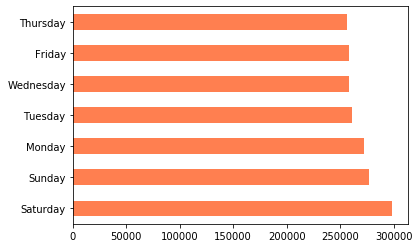

In [15]:
data['DAY_OF_WEEK'].value_counts().plot(kind='barh',color='coral')
plt.show()

In [16]:
'''So fires are slightly more likely to start/be discovered on the weekend. I imagine these fires are due to 
people being careless with campfires or smoking or possibly malicious fires, I doubt fires due
natural causes such as lightning strikes would increase at the weekend. But let's test that:'''

"So fires are slightly more likely to start/be discovered on the weekend. I imagine these fires are due to \npeople being careless with campfires or smoking or possibly malicious fires, I doubt fires due\nnatural causes such as lightning strikes would increase at the weekend. But let's test that:"

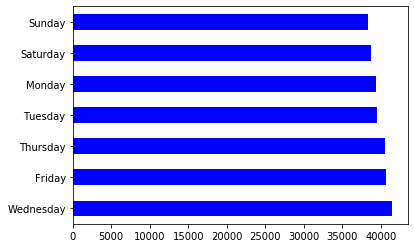

In [17]:
df_lightning = data[data['STAT_CAUSE_DESCR']=='Lightning']
df_lightning['DAY_OF_WEEK'].value_counts().plot(kind='barh',color='b')
plt.show()

In [18]:
'''There is some small variation but now the weekend is
lower. I wonder if the general increase at the weekend is due to malicious fires - Arson:'''

'There is some small variation but now the weekend is\nlower. I wonder if the general increase at the weekend is due to malicious fires - Arson:'

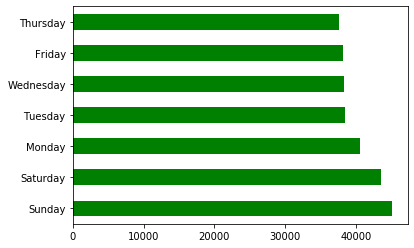

In [19]:
df_arson=data[data['STAT_CAUSE_DESCR']=='Arson']
df_arson['DAY_OF_WEEK'].value_counts().plot(kind='barh',color='g')
plt.show()

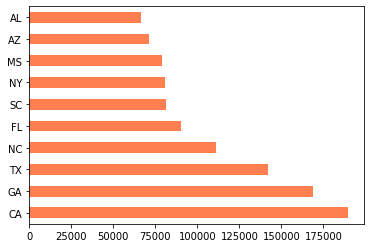

In [20]:
data['STATE'].value_counts().head(n=10).plot(kind='barh',color='coral')
plt.show()

In [21]:
#Finding the data about the tp 3states in terms of fire
df_CA = data[data['STATE']=='CA']
df_GA = data[data['STATE']=='GA']
df_TX = data[data['STATE']=='TX']

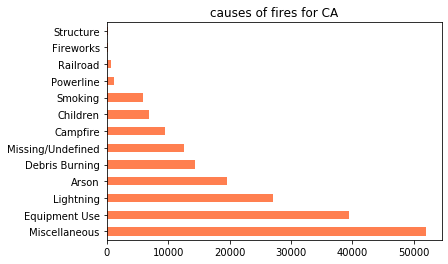

In [22]:
#Highest or the main cause of th fire in the CA state
df_CA['STAT_CAUSE_DESCR'].value_counts().plot(kind='barh',color='coral',title='causes of fires for CA')
plt.show()

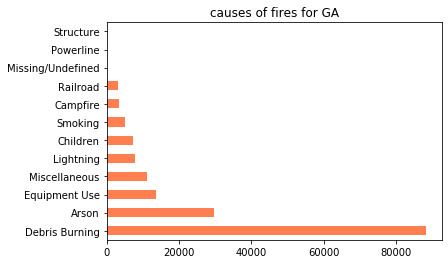

In [23]:
df_GA['STAT_CAUSE_DESCR'].value_counts().plot(kind='barh',color='coral',title='causes of fires for GA')
plt.show()

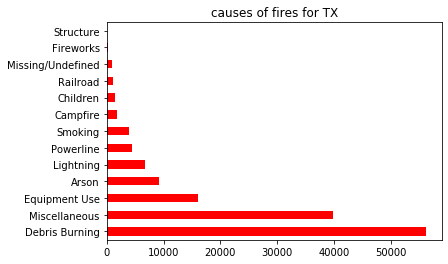

In [24]:
df_TX['STAT_CAUSE_DESCR'].value_counts().plot(kind='barh',color='r',title='causes of fires for TX')
plt.show()

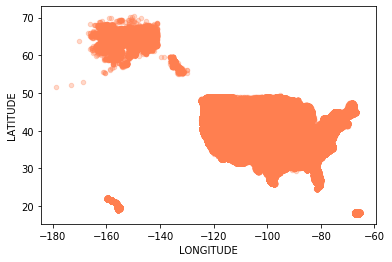

In [25]:
data.plot(kind='scatter',x='LONGITUDE',y='LATITUDE',color='coral',alpha=0.3)
plt.show()

In [26]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1880465 entries, 0 to 1880464
Data columns (total 10 columns):
FIRE_YEAR           int64
STAT_CAUSE_DESCR    object
LATITUDE            float64
LONGITUDE           float64
STATE               object
DISCOVERY_DATE      float64
FIRE_SIZE           float64
DATE                datetime64[ns]
MONTH               int64
DAY_OF_WEEK         object
dtypes: datetime64[ns](1), float64(4), int64(2), object(3)
memory usage: 143.5+ MB


In [27]:
le = preprocessing.LabelEncoder()
data['STAT_CAUSE_DESCR'] = le.fit_transform(data['STAT_CAUSE_DESCR'])
data['STATE'] = le.fit_transform(data['STATE'])
data['DAY_OF_WEEK'] = le.fit_transform(data['DAY_OF_WEEK'])
print(data.head())

   FIRE_YEAR  STAT_CAUSE_DESCR   LATITUDE   LONGITUDE  STATE  DISCOVERY_DATE  \
0       2005                 7  40.036944 -121.005833      4       2453403.5   
1       2004                 6  38.933056 -120.404444      4       2453137.5   
2       2004                 3  38.984167 -120.735556      4       2453156.5   
3       2004                 6  38.559167 -119.913333      4       2453184.5   
4       2004                 6  38.559167 -119.933056      4       2453184.5   

   FIRE_SIZE       DATE  MONTH  DAY_OF_WEEK  
0       0.10 2005-02-02      2            6  
1       0.25 2004-05-12      5            6  
2       0.10 2004-05-31      5            1  
3       0.10 2004-06-28      6            1  
4       0.10 2004-06-28      6            1  


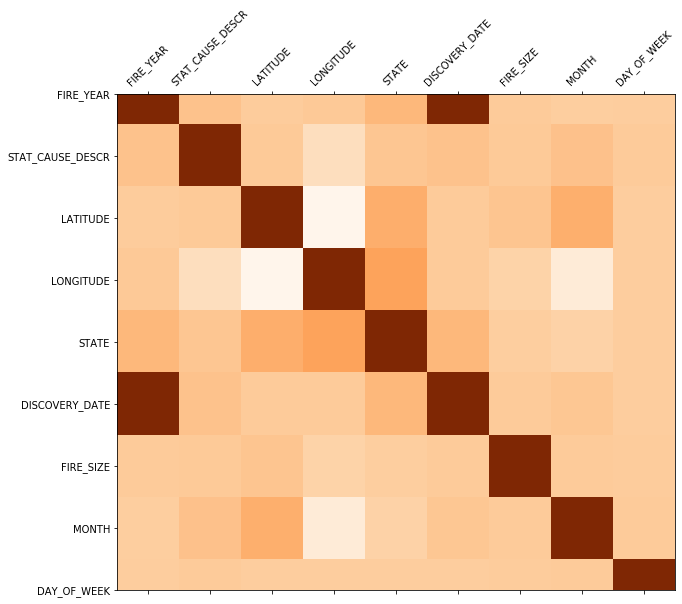

In [28]:
def plot_corr(df,size=10):
    corr = df.corr()  #the default method is pearson
    fig, ax = plt.subplots(figsize=(size, size))
    ax.matshow(corr,cmap=plt.cm.Oranges)
    plt.xticks(range(len(corr.columns)), corr.columns)
    plt.yticks(range(len(corr.columns)), corr.columns)
    for tick in ax.get_xticklabels():
        tick.set_rotation(45)    
    plt.show()
    
plot_corr(data)

In [29]:
data = data.drop('DATE',axis=1)
data = data.dropna()

In [30]:
#getting the numerical data for machine learning 
#.values return the array which is the original requirement of the machine learning model
X = data.drop(['STAT_CAUSE_DESCR'], axis=1).values
y = data['STAT_CAUSE_DESCR'].values

In [31]:
X

array([[ 2.00500000e+03,  4.00369444e+01, -1.21005833e+02, ...,
         1.00000000e-01,  2.00000000e+00,  6.00000000e+00],
       [ 2.00400000e+03,  3.89330556e+01, -1.20404444e+02, ...,
         2.50000000e-01,  5.00000000e+00,  6.00000000e+00],
       [ 2.00400000e+03,  3.89841667e+01, -1.20735556e+02, ...,
         1.00000000e-01,  5.00000000e+00,  1.00000000e+00],
       ...,
       [ 2.01500000e+03,  3.76176192e+01, -1.20938570e+02, ...,
         1.00000000e-01,  5.00000000e+00,  2.00000000e+00],
       [ 2.01500000e+03,  3.76722347e+01, -1.20898356e+02, ...,
         2.00000000e+00,  1.00000000e+01,  6.00000000e+00],
       [ 2.01500000e+03,  3.42632170e+01, -1.16830950e+02, ...,
         1.00000000e-01,  3.00000000e+00,  2.00000000e+00]])

In [32]:
y

array([7, 6, 3, ..., 8, 8, 7])

In [33]:
data['STAT_CAUSE_DESCR'].nunique()

13

In [34]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=0)

In [35]:
#Building the ensemble method model
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,BaggingClassifier,ExtraTreesClassifier
from sklearn.metrics import confusion_matrix,classification_report
classifier=RandomForestClassifier(n_estimators=10)
classifier.fit(X_train,y_train)
y_pred = classifier.predict(X_test)

In [36]:
cm=confusion_matrix(y_test,y_pred)
print(cm)
acc_score=classification_report(y_test,y_pred)
print("\n\n")
print(acc_score)

[[46164   998  1444 20668  2746   170  1928  8093  1062    92   270   514
     21]
 [ 1809  7550   372  4323  1092    70  3793  2907   467    35   139   255
      6]
 [ 3105   490  2912  5693  1341   143   869  2605   291    37   399   322
     33]
 [21870  2629  2470 80358  4799   216  3052 10910   957   255   588   928
     67]
 [ 4836  1054  1082 11070 12515   135  3120  8105   728   204   996   457
     27]
 [  365   108   140   422   181  1349   357   383    47    21     9    25
      8]
 [ 2083  1802   354  3491  1686   124 68403  3802  1022    95   252   191
     11]
 [ 9954  2761  1715 19225  7589   307  5970 45845  1646   272   709   988
     45]
 [  993   428   160  1382   657    33  2639  1897 41972    29    16    90
      4]
 [  388   102    81  1246   468    34   440  1040    84   348    11    36
     11]
 [  748   266   243  1809  1147    21   897   755    60    11  4031    65
      0]
 [ 2145   849   606  4994  1319    43  1080  3556   238    32   172   884
      7]
 [  

In [37]:
def set_label(cat):
    cause = 0
    natural = ['Lightning']
    accidental = ['Structure','Fireworks','Powerline','Railroad','Smoking','Children','Campfire','Equipment Use','Debris Burning']
    malicious = ['Arson']
    other = ['Missing/Undefined','Miscellaneous']
    if cat in natural:
        cause = 1
    elif cat in accidental:
        cause = 2
    elif cat in malicious:
        cause = 3
    else:
        cause = 4
    return cause
     
data['LABEL'] = df_orig['STAT_CAUSE_DESCR'].apply(lambda x: set_label(x)) # I created a copy of the original df earlier in the kernel
data = data.drop('STAT_CAUSE_DESCR',axis=1)
print(data.head())

   FIRE_YEAR   LATITUDE   LONGITUDE  STATE  DISCOVERY_DATE  FIRE_SIZE  MONTH  \
0       2005  40.036944 -121.005833      4       2453403.5       0.10      2   
1       2004  38.933056 -120.404444      4       2453137.5       0.25      5   
2       2004  38.984167 -120.735556      4       2453156.5       0.10      5   
3       2004  38.559167 -119.913333      4       2453184.5       0.10      6   
4       2004  38.559167 -119.933056      4       2453184.5       0.10      6   

   DAY_OF_WEEK  LABEL  
0            6      4  
1            6      1  
2            1      2  
3            1      1  
4            1      1  


In [38]:
X = data.drop(['LABEL'], axis=1).values
y = data['LABEL'].values
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=0)
clf_rf = RandomForestClassifier(n_estimators=50)
clf_rf = clf_rf.fit(X_train, y_train)
print(clf_rf.score(X_test,y_test))

0.700997979225015


In [39]:
print(df_CA.head())

   FIRE_YEAR STAT_CAUSE_DESCR   LATITUDE   LONGITUDE STATE  DISCOVERY_DATE  \
0       2005    Miscellaneous  40.036944 -121.005833    CA       2453403.5   
1       2004        Lightning  38.933056 -120.404444    CA       2453137.5   
2       2004   Debris Burning  38.984167 -120.735556    CA       2453156.5   
3       2004        Lightning  38.559167 -119.913333    CA       2453184.5   
4       2004        Lightning  38.559167 -119.933056    CA       2453184.5   

   FIRE_SIZE       DATE  MONTH DAY_OF_WEEK  
0       0.10 2005-02-02      2   Wednesday  
1       0.25 2004-05-12      5   Wednesday  
2       0.10 2004-05-31      5      Monday  
3       0.10 2004-06-28      6      Monday  
4       0.10 2004-06-28      6      Monday  


In [40]:
def set_arson_label(cause):
    arson = 0
    if cause == 'Arson':
        arson = 1
    return arson
     

df_CA['ARSON'] = df_CA['STAT_CAUSE_DESCR'].apply(lambda x: set_arson_label(x)) 
print(df_CA.head())

   FIRE_YEAR STAT_CAUSE_DESCR   LATITUDE   LONGITUDE STATE  DISCOVERY_DATE  \
0       2005    Miscellaneous  40.036944 -121.005833    CA       2453403.5   
1       2004        Lightning  38.933056 -120.404444    CA       2453137.5   
2       2004   Debris Burning  38.984167 -120.735556    CA       2453156.5   
3       2004        Lightning  38.559167 -119.913333    CA       2453184.5   
4       2004        Lightning  38.559167 -119.933056    CA       2453184.5   

   FIRE_SIZE       DATE  MONTH DAY_OF_WEEK  ARSON  
0       0.10 2005-02-02      2   Wednesday      0  
1       0.25 2004-05-12      5   Wednesday      0  
2       0.10 2004-05-31      5      Monday      0  
3       0.10 2004-06-28      6      Monday      0  
4       0.10 2004-06-28      6      Monday      0  


/home/tarun/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [41]:
df_CA = df_CA.drop('DATE',axis=1)
df_CA = df_CA.drop('STATE',axis=1)
df_CA = df_CA.drop('STAT_CAUSE_DESCR',axis=1)
df_CA = df_CA.drop('FIRE_SIZE',axis=1)
df_CA = df_CA.dropna()

le = preprocessing.LabelEncoder()
df_CA['DAY_OF_WEEK'] = le.fit_transform(df_CA['DAY_OF_WEEK'])

print(df_CA.head())

   FIRE_YEAR   LATITUDE   LONGITUDE  DISCOVERY_DATE  MONTH  DAY_OF_WEEK  ARSON
0       2005  40.036944 -121.005833       2453403.5      2            6      0
1       2004  38.933056 -120.404444       2453137.5      5            6      0
2       2004  38.984167 -120.735556       2453156.5      5            1      0
3       2004  38.559167 -119.913333       2453184.5      6            1      0
4       2004  38.559167 -119.933056       2453184.5      6            1      0


In [42]:
X = df_CA.drop(['ARSON'], axis=1).values
y = df_CA['ARSON'].values
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=0) #30% for testing, 70% for training
clf_rf = RandomForestClassifier(n_estimators=100)
clf_rf = clf_rf.fit(X_train, y_train)
print(clf_rf.score(X_test,y_test))

0.9208827925789149


In [43]:
'''

So this meets the goal of 90% or better.

Summary: Given some basic data, the kind of data available when a fire is first discovered, it is possible to
predict with some accuracy if the fire was the result of arson.
'''

'\n\nSo this meets the goal of 90% or better.\n\nSummary: Given some basic data, the kind of data available when a fire is first discovered, it is possible to\npredict with some accuracy if the fire was the result of arson.\n'